<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/rectify_snirf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Common Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import compress

In [3]:
import h5py
import numpy as np

In [4]:
import os


# Clona .snirf original

In [19]:
def clone_snirf(path_in, path_out, fname='out.snirf'):
  
  if path_in == path_out:
    print('Error: path_in and path_out can not be the same.') 
    return

  if not os.path.exists(path_out):
      os.mkdir(path_out)
      print("Directory " , path_out ,  "was created")
  else:    
      print("Warning: directory " , path_out ,  " already exists")

  if os.path.exists(path_out + fname):
    os.remove(path_out + fname)
    print('Warning: previous output file was deleted.')
  
  print('Input snirf file: ' + path_in + fname)

  fs = h5py.File(path_in + fname,'r')
  fd = h5py.File(path_out + fname,'w')

  if list(fs.keys()).count('formatVersion') >= 1:
    fs.copy('formatVersion',fd,'formatVersion') 
  else:
    print('Warning: there is no formatVersion key in snirf input.')

  if list(fs.keys()).count('nirs') >= 1:
    fs.copy('nirs',fd,'nirs') 
  else:
    print('Error: Invalid snirf file. There is no nirs key in snirf input.')  
  
  print('Output snirf file: ' + path_out + fname)
  
  fd.close()
  fs.close()

  return

In [20]:
path_in = '/content/drive/MyDrive/coletas IC TCC/dados em .snirf/'
path_out= '/content/snirf/'

fname = 'JMVR_TCC_40.snirf'

clone_snirf(path_in, path_out, fname=fname)

Input snirf file: /content/drive/MyDrive/coletas IC TCC/dados em .snirf/JMVR_TCC_40.snirf
Output snirf file: /content/snirf/JMVR_TCC_40.snirf


# Le novo .snirf

In [21]:
path_out='/content/snirf/'

data = h5py.File(path_out + fname,'r+')

In [22]:
if data.keys() != h5py.File(path_in + fname,'r').keys():
  print('Error: new snirf file with different keys from source')

## Create Channels Table

In [27]:
for key in data['nirs'].keys():
  exp = key + ' = data["nirs"]["' + key + '"] '
  print(exp)
  exec(exp)

aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim1 = data["nirs"]["stim1"] 


In [25]:
def create_channels_table(data,reorder=False):

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # Parameters: 
  # data: snirf file read

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    print(exp)
    exec(exp)
    
  measurements = [ x for x in list( data1.keys() ) if x.find('measurementList') == 0 ]

  measure_idx = []
  name = []
  source =  []
  detector = []
  source_pos = []
  detector_pos = []
  source_pos_3D = []
  detector_pos_3D = []
  flag_2D = True
  flag_3D = True
  frequencies = []

  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    e_source = int(data1[m]['sourceIndex'][0])   
    e_detector = int(data1[m]['detectorIndex'][0]) 
    
    if list(probe.keys()).count('sourcePos2D') > 0 and list(probe.keys()).count('detectorPos2D') > 0: 
      e_source_pos = probe['sourcePos2D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos = probe['detectorPos2D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_2D = False
      e_source_pos = e_detector_pos = np.array([0,0],dtype=float)

    # e_frequencies = probe['frequencies'][0]

    if list(probe.keys()).count('sourcePos3D') > 0 and list(probe.keys()).count('detectorPos3D') > 0:
      e_source_pos_3D = probe['sourcePos3D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos_3D = probe['detectorPos3D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_3D = False
      e_source_pos_3D = e_detector_pos_3D = np.array([0,0,0],dtype=float)

    name.append( e_name )
    source.append( e_source )
    detector.append( e_detector )
    source_pos.append( e_source_pos )
    detector_pos.append( e_detector_pos )
  #  frequencies.append( e_frequencies )
    source_pos_3D.append( e_source_pos_3D )
    detector_pos_3D.append( e_detector_pos_3D )

  if not flag_2D:
    print('WARNING: no source, detector pos 2D available\n')

  if not flag_3D:
    print('WARNING: no source, detector pos 3D available\n')

  # print(measure_idx)  
  # print(name)  
  # print(source)
  # print(detector)
  # print(source_pos)
  # print(detector_pos)
  # print(frequencies)
  # print(source_pos_3D)
  # print(detector_pos_3D)

  measures = pd.DataFrame({'measure_idx':measure_idx,
                          'name':name,
                          'source':source,
                          'detector':detector,
  #                         'frequencies':frequencies,
                          'source_pos':source_pos,
                          'detector_pos':detector_pos,
                          'source_pos_3D':source_pos_3D,
                          'detector_pos_3d':detector_pos_3D}) # .sort_values('measure_idx').reset_index(drop=True)
  # measures.head()

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  # wavelength
  measures['wavelength'] = wavelength 
  measures['name'] = measures['name'] + '_' + wavelength 
  measures.set_index('measure_idx',inplace=True) 

  measures = measures[['name', 'source', 'detector', 'wavelength', 'source_pos', 'detector_pos',
        'source_pos_3D', 'detector_pos_3d']]
  measures = measures.rename_axis('')
  measures.head()

  if reorder:
    measures = measures.sort_values('name')

  return measures.reset_index(drop=True)




In [29]:
channels_table = create_channels_table(data)
display(channels_table)

aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim1 = data["nirs"]["stim1"] 


,name,source,detector,wavelength,source_pos,detector_pos,source_pos_3D,detector_pos_3d
0,S1_D2_685,1,2,685,"[-0.6971986924144571, -0.30110181336228425]","[-0.7971698082717102, -0.4740390731968549]","[-0.6971986924144571, -0.30110181336228425, 0....","[-0.7971698082717102, -0.4740390731968549, -0...."
1,S2_D1_830,2,1,830,"[-0.3294117473795839, 0.20432093641934795]","[-0.0030518993174782193, 0.33899389248086537]","[-0.3294117473795839, 0.20432093641934795, 0.1...","[-0.0030518993174782193, 0.33899389248086537, ..."
2,S2_D4_685,2,4,685,"[-0.3294117473795839, 0.20432093641934795]","[-0.6196709896538208, 0.022376067732315753]","[-0.3294117473795839, 0.20432093641934795, 0.1...","[-0.6196709896538208, 0.022376067732315753, -0..."
3,S2_D4_830,2,4,830,"[-0.3294117473795839, 0.20432093641934795]","[-0.6196709896538208, 0.022376067732315753]","[-0.3294117473795839, 0.20432093641934795, 0.1...","[-0.6196709896538208, 0.022376067732315753, -0..."
4,S2_D5_685,2,5,685,"[-0.3294117473795839, 0.20432093641934795]","[-0.4014320187223603, 0.27499115873426083]","[-0.3294117473795839, 0.20432093641934795, 0.1...","[-0.4014320187223603, 0.27499115873426083, -0...."
5,S2_D5_830,2,5,830,"[-0.3294117473795839, 0.20432093641934795]","[-0.4014320187223603, 0.27499115873426083]","[-0.3294117473795839, 0.20432093641934795, 0.1...","[-0.4014320187223603, 0.27499115873426083, -0...."
6,S2_D13_685,2,13,685,"[-0.3294117473795839, 0.20432093641934795]","[-0.22816472456519135, 0.3152773294980886]","[-0.3294117473795839, 0.20432093641934795, 0.1...","[-0.22816472456519135, 0.3152773294980886, -0...."
7,S2_D13_830,2,13,830,"[-0.3294117473795839, 0.20432093641934795]","[-0.22816472456519135, 0.3152773294980886]","[-0.3294117473795839, 0.20432093641934795, 0.1...","[-0.22816472456519135, 0.3152773294980886, -0...."
8,S3_D10_685,3,10,685,"[0.7678386588154142, -0.2993543116875682]","[0.71462959020154, -0.1282742553817132]","[0.7678386588154142, -0.2993543116875682, 0.07...","[0.71462959020154, -0.1282742553817132, -0.069..."
9,S3_D10_830,3,10,830,"[0.7678386588154142, -0.2993543116875682]","[0.71462959020154, -0.1282742553817132]","[0.7678386588154142, -0.2993543116875682, 0.07...","[0.71462959020154, -0.1282742553817132, -0.069..."


In [32]:
def create_channels_raw(data,reorder=False):

  # Parameters: 
  # data: snirf file read

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    exec(exp)

  measurements = [ x for x in list( data1.keys() ) if x.find('measurementList') == 0 ]

  measure_idx = []
  name = [] 
  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    name.append( e_name )

  measures = pd.DataFrame({'name':name})

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  measures['name'] = measures['name'] + '_' + wavelength 

  # print(measures)

  raw = pd.concat([pd.DataFrame(data1['time']), pd.DataFrame(data1['dataTimeSeries'])], axis=1)
  raw.columns = ['time'] + list(measures.name) 
  
  if reorder:
    df_temp = raw.drop(columns='time')
    df_temp = df_temp.reindex(sorted(df_temp.columns), axis=1)
    df_temp = pd.concat([raw.time,df_temp], axis=1 )
    raw = df_temp 

  return raw

In [33]:
channels_raw = create_channels_raw(data)
display(channels_raw)

,time,S1_D2_685,S2_D1_830,S2_D4_685,S2_D4_830,S2_D5_685,S2_D5_830,S2_D13_685,S2_D13_830,S3_D10_685,S3_D10_830,S3_D6_685,S1_D2_830,S3_D6_830,S3_D7_685,S3_D7_830,S3_D8_685,S3_D8_830,S4_D1_685,S4_D1_830,S4_D11_685,S4_D11_830,S4_D8_685,S1_D3_685,S4_D8_830,S4_D9_685,S4_D9_830,S1_D3_830,S1_D4_685,S1_D4_830,S1_D12_685,S1_D12_830,S2_D1_685
0,0.000000,2327.247070,43619.570312,1335.787598,27514.988281,639.397400,16925.009766,265.649658,4057.641113,171.021072,71.226967,421.852539,3288.960693,10115.106445,71434.203125,614.759827,3112.912598,2084.343018,9700.326172,16262.985352,67253.742188,9829.968750,58817.628906,4018.185303,21751.566406,-267.934937,212.482422,1161.036377,2407.873047,1326.221191,3300.440186,28063.833984,56817.980469
1,0.100000,2279.193848,42429.433594,1238.186523,28281.765625,726.261414,17029.722656,235.921616,4045.492432,42.838802,292.632538,653.934143,3725.472656,11184.814453,74140.007812,637.708862,3241.955078,2086.496094,9584.943359,16668.222656,65777.015625,9938.248047,60173.843750,3943.771484,21848.820312,45.136852,403.018524,1181.382324,2459.626221,1176.386353,3047.649902,28033.505859,56864.429688
2,0.200000,2295.409424,42769.781250,1130.955688,28598.941406,791.939331,17184.630859,241.185837,4088.783691,37.143017,302.625427,524.939636,3780.884766,11006.286133,75219.640625,630.996826,3284.731689,2112.640625,9679.371094,16732.851562,66593.429688,9993.852539,60652.257812,4004.606201,22092.880859,23.765341,437.382538,1188.921143,2492.593262,1175.171265,3098.326660,28308.625000,57712.613281
3,0.300000,2391.978271,43149.937500,1311.821899,28785.191406,674.686279,17340.277344,244.095795,4114.539551,30.622953,331.423981,504.877686,3667.291992,11037.792969,75552.218750,631.055542,3304.547852,2114.345215,9702.814453,16765.638672,67134.742188,9964.814453,60924.957031,3978.155518,22158.957031,49.182415,515.514038,1188.387207,2503.842529,1210.305664,3088.042236,28396.019531,58161.726562
4,0.400000,2325.032715,43375.542969,1298.807983,29231.992188,636.497070,17510.677734,246.303314,4155.176270,67.600159,274.400635,507.979584,3807.428467,11061.408203,76082.390625,627.097595,3311.201172,2113.768799,9726.126953,16893.919922,67635.539062,10007.638672,61206.207031,4005.289062,22232.345703,1.869870,459.525726,1197.576904,2518.030029,1191.745728,3160.044922,28525.105469,58772.042969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18574,1857.400024,1980.004517,35223.390625,949.670776,24431.470703,719.508118,15868.756836,251.386597,4064.652344,121.998398,539.508606,407.775238,3814.130859,7956.907715,61793.929688,460.208679,3093.267334,2303.367676,10437.811523,12052.603516,46536.074219,9409.061523,54686.660156,3599.826904,19569.693359,-6.697336,473.427887,898.318726,2190.280273,790.539001,2533.930420,15110.911133,33614.839844
18575,1857.500000,2012.015503,35397.824219,1087.596924,24652.087891,683.321899,16083.922852,250.213562,4110.864258,59.214806,533.223572,387.162201,3853.529297,7998.825684,62096.753906,467.966522,3107.536377,2298.374512,10450.227539,12109.280273,46907.605469,9331.631836,54936.636719,3560.690186,19621.859375,24.763021,460.904633,897.909058,2198.818115,767.567322,2487.770020,15228.173828,33991.996094
18576,1857.599976,1973.697510,35620.953125,1032.225098,24874.000000,709.920349,16227.776367,253.397476,4162.170898,-0.806300,608.271606,411.499084,3897.427490,7823.698730,62612.183594,460.486481,3130.564941,2305.041992,10465.723633,12160.885742,47340.328125,9340.482422,55247.621094,3602.880859,19738.140625,49.178455,477.892059,915.734375,2214.663086,791.030823,2563.029541,15372.288086,34375.128906
18577,1857.699951,1962.037598,35506.718750,891.490173,24900.861328,698.119385,16218.121094,257.624603,4136.180664,-40.385674,577.669678,439.386383,3896.792480,7886.911133,62543.593750,462.627167,3121.290039,2292.961914,10454.765625,12028.767578,46657.738281,9464.306641,55290.867188,3580.457520,19661.328125,-24.019081,482.881836,909.568787,2211

In [35]:
from sklearn.preprocessing import scale

def normalize_channels(df):
  df_scaled = df.drop(columns='time').copy()
  
  for c in df_scaled:
    df_scaled[c] = scale( df_scaled[c] )

  df_scaled = pd.concat([df.time,df_scaled],axis=1)
  return df_scaled 

# normalize_channels(channels_raw)

In [36]:
def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16)):

  f = plt.figure( figsize=figsize )

  if normalize:
    df_not_scaled = df.copy()
    df = normalize_channels(df)
  else:
    df_not_scaled = df # the same

  inicio = 0  
  inc = 6
  add_inc = 0
  ticks = []

  col_order = df.drop(columns='time').columns.sort_values()

  for c in col_order:
    if not reds:
      sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc )
    else:
      if df_not_scaled[c].min() < 0:
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color='r', alpha=0.8)
      else:
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc , alpha=0.5 , color='gray')

    ticks.append(inicio + add_inc)
    add_inc = add_inc + inc
    
  ylim = f.gca().get_ylim()[1]

  # for c in group_nirs['group']['stimulus'].drop(columns='time'):
  #  plt.plot(stimulus['time'],stimulus[c]*ylim,label=c,lw=1,linestyle='dashed')

  # plt.legend()
  if normalize:
    plt.yticks(ticks = ticks, labels = list( col_order ))
    plt.ylabel('')
  else:
    plt.ylabel('Channel Values')

  plt.show()

  return 

# plotchannels_all(channels_raw)
# plotchannels_all(channels_raw,normalize=True,figsize=(10,10))


In [37]:
def check_sample_rate(df):

  sample_rate = np.float(df.time[-1:] / len(df.time))
  print('Sample rate: ', sample_rate, 'in sec.')

  total_time =  df.time[-1:].values[0]
  print('Total time: ',   total_time , 'in sec.')

  resample = None 

  if not all( channels_raw.time.diff()[1::]*10 == channels_raw.time.diff()[1]*10 ):
    print('Warning: time seems have different intervals. For better signal processing sample rate should be constant. Try to check and correct this.')
    print('Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)')

    resample_time = np.round( np.arange(0,len(df),1)/10 , 1)

  return sample_rate, total_time, resample_time

# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

# to change...
# channels_raw.time = resample_time
# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

In [38]:
def perc_negatives(s_neg):
#
# Parameters:
# s_neg: np.array with negatives values
#
# Returns:
# perc_neg: % of negatives values
#
# Test:
# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  return len( np.array(np.where( s_neg < 0 )).ravel() ) / len(s_neg)

# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

# channels_raw.drop(columns='time').apply(perc_negatives) 

In [39]:
from matplotlib import pylab
from google.colab import widgets

def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True):

  chnames = df.drop(columns='time').columns.sort_values()

  if individuals:
    tabnames = chnames.to_list()

    # Mark tabnames with '()' for channels with negative values
    for i in range(len(tabnames)):
      if df[ tabnames[i] ].min() < 0:
        tabnames[i] = '(' + tabnames[i] + ')'
  else:
    tabnames = []

  # Add other tabs
  before = 0
  
  if normalized:
    tabnames = ['Normalized'] + tabnames 
    before = before + 1

  if all:
    tabnames = ['All'] + tabnames 
    before = before + 1

  if statistics:
    tabnames = tabnames + ['Statistics']

  tb = widgets.TabBar(tabnames)

  if all:
    with tb.output_to(tabnames.index('All')):
      plotchannels_all(df,reds=True)

  if normalized:
    with tb.output_to(tabnames.index('Normalized')):
      plotchannels_all(df,reds=True,normalize=True)

  if individuals:
    for i in range(len(chnames)):
      # Only select the first 2 tabs, and render others in the background.
      with tb.output_to(i+before, select=(i+before < before)): # +2 because ['All','Normalized']
        if reds:
          plt.plot(df.time, df[chnames[i]], color=['blue','red'][df[chnames[i]].min() < 0] )
        else:
          plt.plot(df.time, df[chnames[i]], color='blue')

  if statistics:
    with tb.output_to(tabnames.index('Statistics'),select=0):
      display( df.drop(columns='time').describe() )
      print()

      neg_true = df.drop(columns='time').apply(min) < 0  

      if any(neg_true):
        print('Warning: There are negative values in signals.')

      for c in neg_true[ neg_true == True ].index:
        if perc_negatives(df[c]) > threshold_neg:
          print(c,'\t...had negative values over ', threshold_neg, ' rate, values should be rescaled to positive')
        else:
          print(c,'\t...had negative values, values should be interpolated')

      print('Warning: Just check sample rate here.')
      check_sample_rate(df)

  return



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

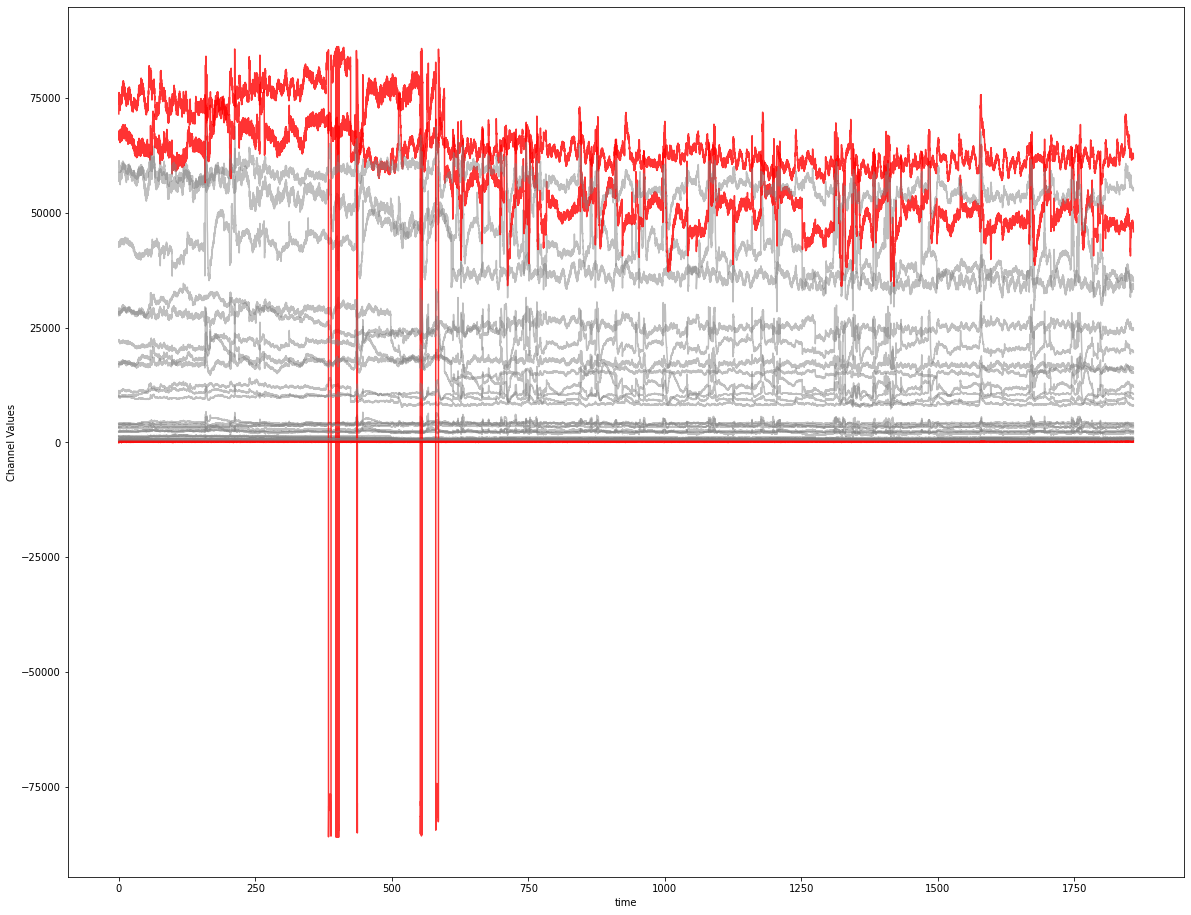

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

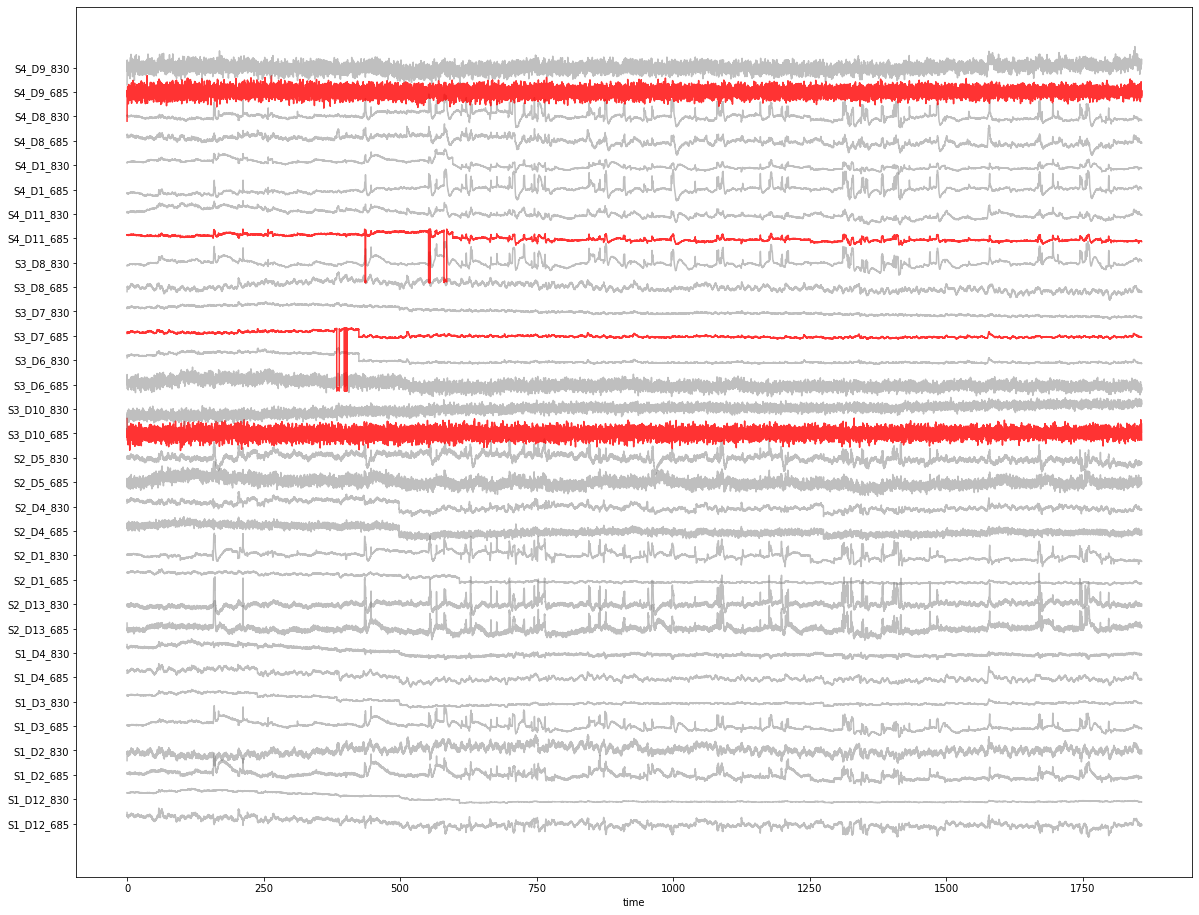

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

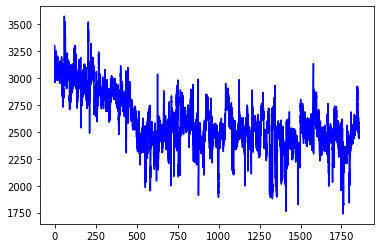

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

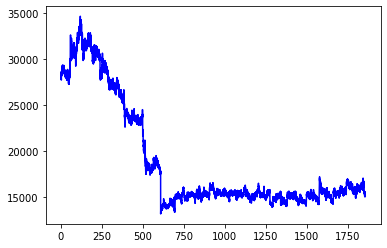

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

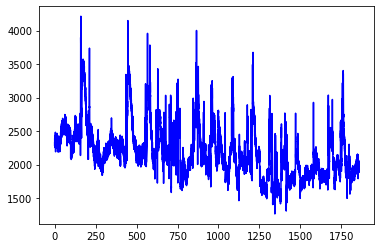

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

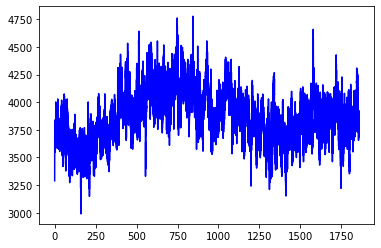

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

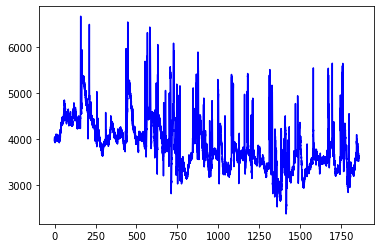

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

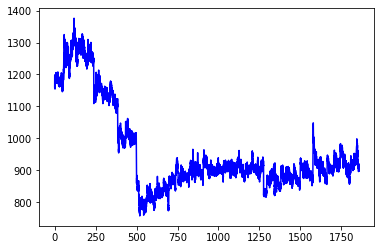

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

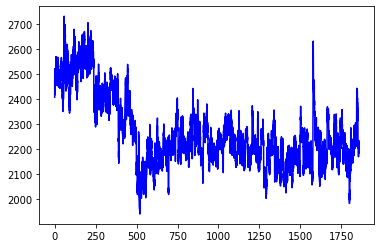

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

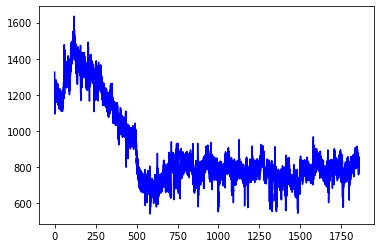

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

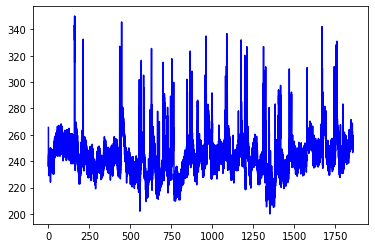

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

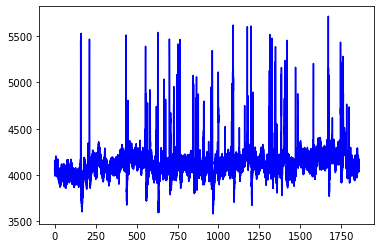

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

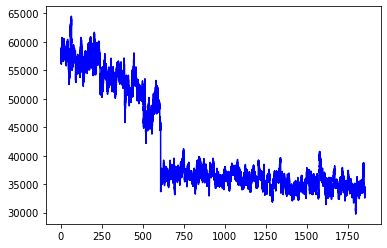

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

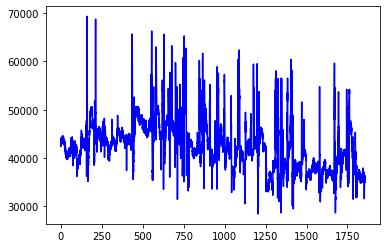

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

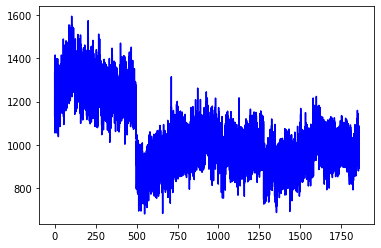

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

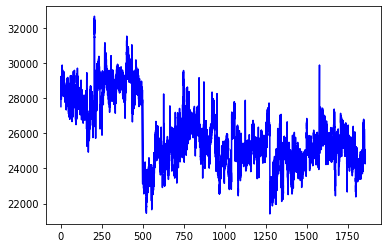

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

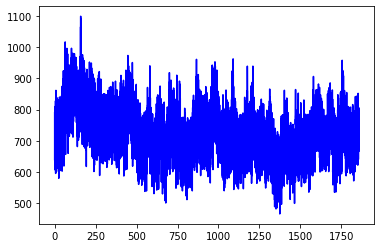

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

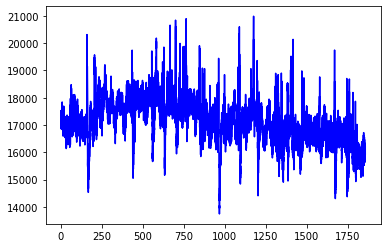

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

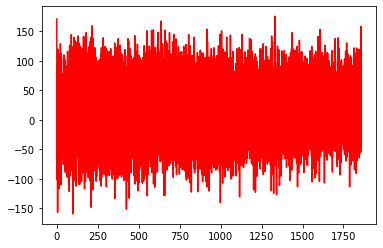

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

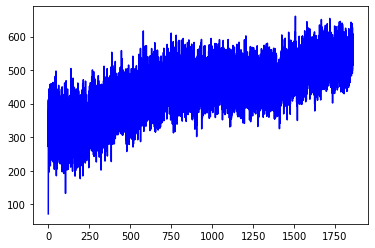

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

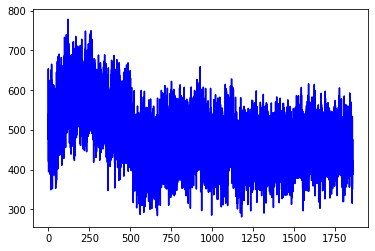

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

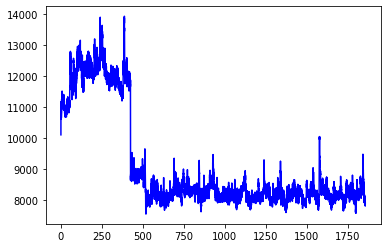

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

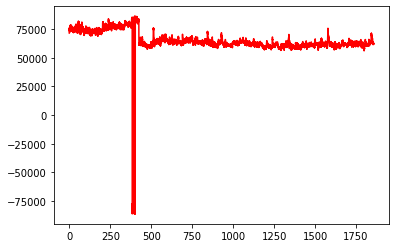

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

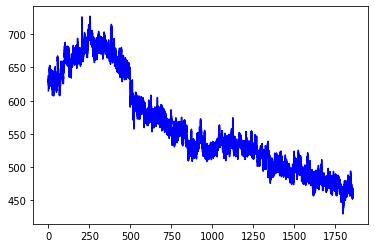

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

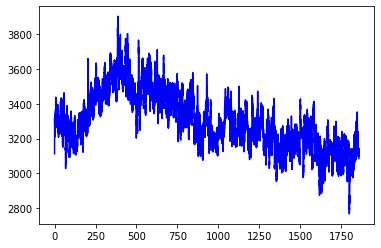

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

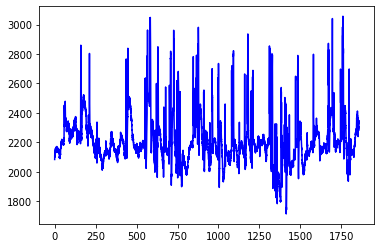

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

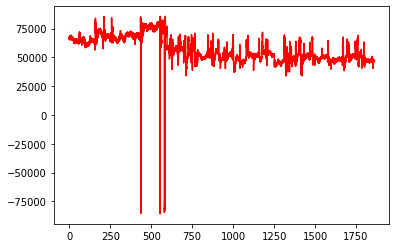

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

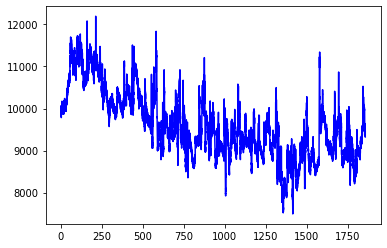

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

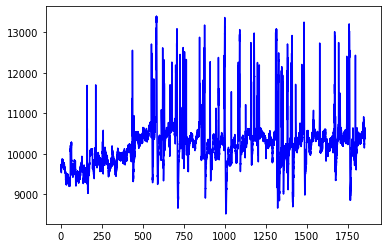

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

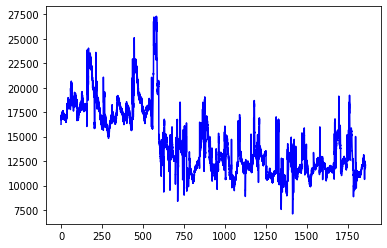

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

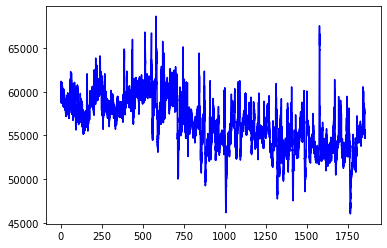

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

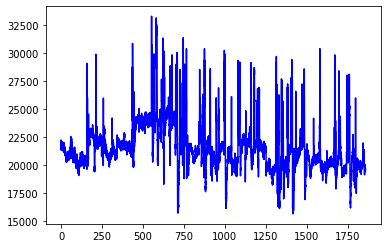

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

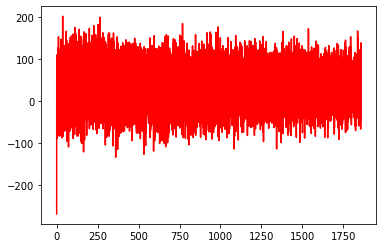

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

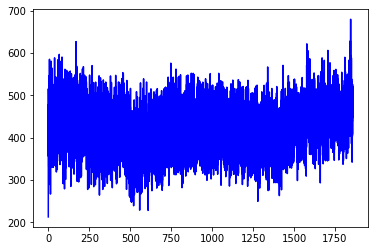

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,S1_D2_685,S2_D1_830,S2_D4_685,S2_D4_830,S2_D5_685,S2_D5_830,S2_D13_685,S2_D13_830,S3_D10_685,S3_D10_830,S3_D6_685,S1_D2_830,S3_D6_830,S3_D7_685,S3_D7_830,S3_D8_685,S3_D8_830,S4_D1_685,S4_D1_830,S4_D11_685,S4_D11_830,S4_D8_685,S1_D3_685,S4_D8_830,S4_D9_685,S4_D9_830,S1_D3_830,S1_D4_685,S1_D4_830,S1_D12_685,S1_D12_830,S2_D1_685
count,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000,18579.000000
mean,2199.975093,42317.566600,1044.759331,25930.769837,721.363013,17104.362174,244.578605,4138.737349,16.506418,443.246252,483.646365,3867.776650,9124.835364,64778.088281,561.923704,3296.505889,2211.398718,10243.154020,14398.167728,56064.873349,9587.097456,56401.862478,3878.331209,21523.016052,32.877192,423.173241,960.419927,2265.866850,888.254600,2595.426142,18872.821987,41575.932913
std,378.737721,4973.901007,156.270634,1834.720110,73.970518,814.576493,15.475805,206.659631,42.020900,75.926369,68.467539,232.250806,1619.905747,11096.873569,70.588739,163.120633,161.952595,633.469475,3288.132917,12955.536371,799.680527,2956.423114,553.526162,2148.768918,41.870581,49.657701,137.112608,138.896203,213.555629,256.308388,5897.511857,8833.886582
min,1264.034302,28421.710938,679.619629,21415.783203,464.715271,13739.968750,200.089600,3579.473389,-159.662125,71.226967,281.047913,2988.848633,7564.468262,-86140.835938,429.427856,2767.014648,1715.101440,8517.236328,7103.439941,-85883.125000,7494.233398,46005.035156,2364.185791,15620.674805,-267.934937,212.482422,756.373474,1939.688965,542.172485,1737.843140,13180.986328,29778.337891
25%,1936.796082,38625.136719,932.428253,24598.757812,670.646057,16596.268555,235.701286,4036.257935,-11.221730,394.063660,435.748032,3705.874146,8120.906494,60899.236328,504.952591,3173.667358,2124.248291,9887.679688,11747.901367,48654.556641,9018.230957,54188.804688,3478.608398,20185.639648,5.253480,389.599823,878.181549,2171.940674,753.251221,2429.533569,15088.782227,35142.927734
50%,2142.534180,42109.183594,1001.802246,25512.224609,716.098694,17080.242188,243.176712,4110.235840,16.751646,452.745880,475.860229,3857.505371,8304.149414,62865.324219,539.430603,3275.453369,2180.335449,10237.444336,13195.685547,53071.777344,9439.592773,56422.917969,3795.693359,21187.994141,32.723698,422.771759,906.325317,2228.640625,801.731079,2547.271484,15518.158203,36704.582031
75%,2393.138794,45154.783203,1156.639648,27301.624023,767.041840,17638.864258,250.801140,4187.607910,45.119823,498.176453,524.373840,4020.696899,8959.573242,67306.171875,629.710815,3416.941162,2264.877930,10456.572754,17006.294922,65051.285156,10100.368164,58647.410156,4211.052734,22302.405273,60.486679,456.071487,996.806000,2335.588623,967.534088,2766.848877,23316.750000,51004.472656
max,4214.162109,69349.820312,1595.711426,32652.941406,1099.618042,20986.628906,349.866333,5714.119141,175.709991,660.373413,778.671753,4778.084473,13939.344727,86099.367188,727.191650,3904.123779,3056.285156,13392.781250,27297.660156,85660.304688,12194.522461,68665.750000,6668.525879,33326.796875,201.623093,680.035034,1376.352051,2732.669922,1635.395142,3576.211426,34637.265625,64506.644531



S3_D10_685 	...had negative values over  0.1  rate, values should be rescaled to positive
S3_D7_685 	...had negative values, values should be interpolated
S4_D11_685 	...had negative values, values should be interpolated
S4_D9_685 	...had negative values over  0.1  rate, values should be rescaled to positive
Sample rate:  0.09999462020712228 in sec.
Total time:  1857.800048828125 in sec.
Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)


<IPython.core.display.Javascript object>

In [40]:
plotchannels_tab(channels_raw,reds=True)  
# plotchannels_tab(channels_raw,reds=True,all=False, normalized=False, statistics=False)

# Ajustando no data frame valores negativos e time

In [41]:
def interpolate_negatives(s_neg, threshold_neg = 0.10):
#
# Parameters:
# s_neg: np.array with less than threshold_neg of negatives values to be interpolate
# threshold_neg: 0.10
#
# Returns:
# s_pos: np.array with values interpolated
#
# Test:
# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  if perc_negatives(s_neg) > threshold_neg:
    print(c,'Error: there are more negative values than threshold_neg. You can try rerun with a different threshold.')
    return None

  xp = np.array(np.where( s_neg >= 0 )).ravel()
  fp = s_neg[ s_neg >= 0 ]
  x = np.array(np.where( s_neg < 0 )).ravel()
  s_new = np.interp(x, xp, fp)

  s_pos = s_neg.copy()
  s_pos[ s_pos < 0 ] = s_new

  return s_pos

# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

In [42]:
def rectify_negatives(df, threshold_neg = 0.10):
 
  neg_true = df.drop(columns='time').apply(min) < 0  

  rectified_negatives = neg_true[ neg_true == True ].index

  for c in rectified_negatives:
    if perc_negatives(df[c]) > threshold_neg:
      df[c] = df[c] + np.abs(df[c].min())
      print(c,'\t...had values rescaled to positive')
    else:
      df[c] = interpolate_negatives(np.array(df[c]))
      print(c,'\t...had negative values interpolated')

  return df, list(rectified_negatives)



In [43]:
channels_raw, rectified_negatives = rectify_negatives(channels_raw, threshold_neg = 0.10) 

S3_D10_685 	...had values rescaled to positive
S3_D7_685 	...had negative values interpolated
S4_D11_685 	...had negative values interpolated
S4_D9_685 	...had values rescaled to positive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

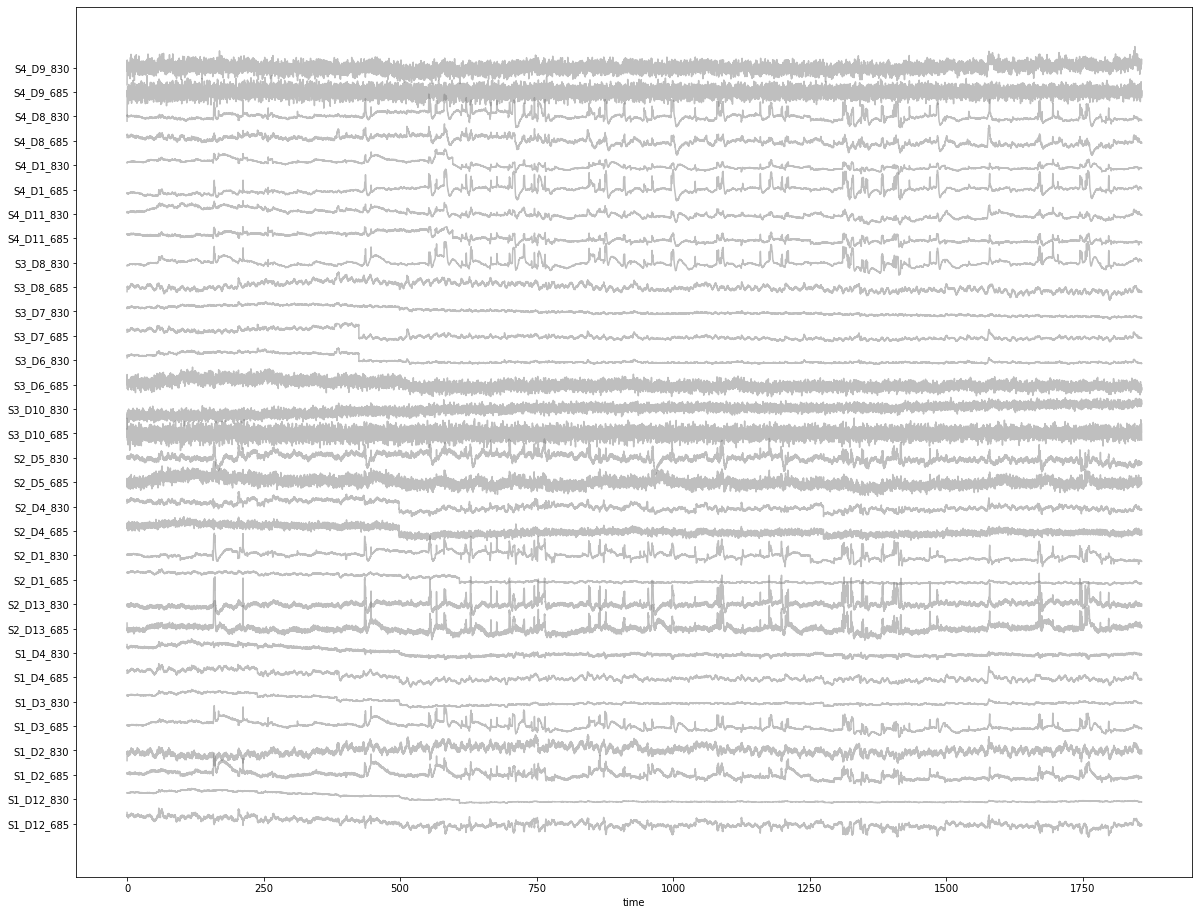

<IPython.core.display.Javascript object>

In [44]:
plotchannels_tab(channels_raw,reds=True,all=False, statistics=False, individuals=False)

In [45]:
print( list(rectified_negatives) )

['S3_D10_685', 'S3_D7_685', 'S4_D11_685', 'S4_D9_685']


In [46]:
sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

channels_raw.time = resample_time

sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

Sample rate:  0.09999462020712228 in sec.
Total time:  1857.800048828125 in sec.
Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)
Sample rate:  0.09999461757898703 in sec.
Total time:  1857.8 in sec.
Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)


# Ajustando o snirf

In [47]:
def add_appname_snirf(data, appname='snirf-Mack'):

  data1 = data['nirs']['data1'] 

  if list(metaDataTags.keys()).count('AppName') == 1:
    metaDataTags['AppName'][...] = [appname]
  else:
    metaDataTags['AppName'] = np.array([appname],dtype='|S13')

  return


In [48]:
add_appname_snirf(data, appname='snirf-Mack')

for key, item in data['nirs']['metaDataTags'].items():
  print(key, item[0])

AppName b'snirf-Mack'
FrequencyUnit b'unknown'
LengthUnit b'mm'
MeasurementDate b'2021-12-04'
MeasurementTime b'15:12:46'
SnirfDraft b'3'
SubjectID b'default'
TimeUnit b'unknown'


In [49]:
def rectify_negatives_snirf(data, channels_raw, rectified_negatives):

  data1 = data['nirs']['data1'] 

  for c in rectified_negatives:
  # print( c, list(channels_raw.columns).index(c) - 1 )
  # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
  # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
    data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]  

  return



In [50]:
rectify_negatives_snirf(data, channels_raw, rectified_negatives) 

In [51]:
def rectify_time_snirf(data, channels_raw):

  data1 = data['nirs']['data1'] 

  data1['time'][...] = channels_raw.time
  # print( data1['time'][...] )

  return

In [52]:
rectify_time_snirf(data, channels_raw)

In [53]:
for c in rectified_negatives:
  # print( c, list(channels_raw.columns).index(c) - 1 )
  # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
  # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
  data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]   
  

## Create Stimulus from Stimulus or Aux

In [55]:
def create_stim_from_aux(data,delete_before=False,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) > 0 and delete_before:
    for s in stim_list:
      del data['nirs'][s]
      print('Warning: previous stim record ' + s + ' was deleted.')

  if len(stim_list) > 0 and not delete_before:
    print('Error: previous stim records ', stim_list,  ' should be deleted before create stim from aux.')
    return

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 
    
#  for a in aux_list:
#    print( data['nirs'][a].keys() )

  stim_aux = False

  for a in aux_list:
    if list(data['nirs'][a].keys()) == ['dataTimeSeries', 'name', 'time', 'timeOffset']: 
      stim_aux = True

  if not stim_aux:
    print('Error: it seems there is no valid aux stim records.')
    return
  else:
    print('Warning: trying to use aux stim records for stimulus. At least one record with dataTimeSeries, name, time and timeOffset.') 

  for a in aux_list:
    data['nirs'][a]['time'][...] = data1['time'][:] # ajusta o tempo
    data['nirs'][a]['dataTimeSeries'][:] = np.round(   data['nirs'][a]['dataTimeSeries'][:], 0) # ajusta o impulso

  for a in aux_list:
    stim = 'stim' + a.split('aux')[1]
    data['nirs'].create_group(stim)
    data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][a]['name'][0]]).astype('|O'))

    start = []
    end = []
    value = []

    start_bool = False

    for i in range( len( aux1['dataTimeSeries'] ) ):
      if data['nirs'][a]['dataTimeSeries'][i] != 0 and not start_bool:
        value.append( data['nirs'][a]['dataTimeSeries'][i] )
        start.append( data['nirs'][a]['time'][i] )
        start_bool = True
      else: 
        if data['nirs'][a]['dataTimeSeries'][i] == 0 and start_bool:  
          end.append( data['nirs'][a]['time'][i-1] )
          start_bool = False

    data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

  for a in aux_list:
    if data['nirs'][a]['timeOffset'][0] != 0:
      print('Warning: aux record ' + a + ' with timeOffset different from 0. timeOffset will be ignored when transformed to stim records.')

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  
  print('Stim records was created: ', stim_list)

  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return 
  




In [56]:
data['nirs']['data1']['dataTimeSeries']

<HDF5 dataset "dataTimeSeries": shape (18579, 32), type "<f8">

In [57]:
def plot_aux_stimulus(data):

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 

  f = plt.figure(figsize=(20,4))

  for a in aux_list:
    plt.plot(data['nirs']['data1']['time'][:], data['nirs'][a]['dataTimeSeries'][:],label=a)

  plt.legend()
  plt.show()

  return

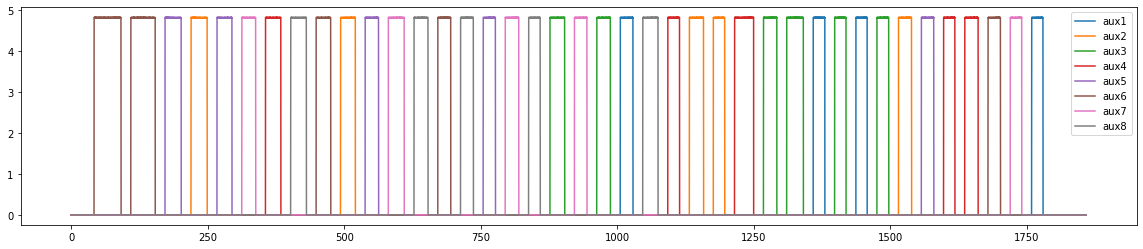

In [58]:
plot_aux_stimulus(data)

In [59]:
create_stim_from_aux(data,delete_before=True,show='stim1')

Stim records was created:  ['stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
Showing stim record  stim1 ...
b'aux1'
[[1005.2   23.2    5. ]
 [1358.6   21.2    5. ]
 [1436.8   20.5    5. ]
 [1758.5   20.7    5. ]]


# Retifica estímulos para 18s

In [60]:
def rectify_stim_duration(data,duration=5,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  for s in stim_list:
    data['nirs'][s]['data'][:,1] = np.ones( data['nirs'][s]['data'].shape[0] )*duration
  
  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return

In [61]:
rectify_stim_duration(data,duration=18,show='stim1') 

Showing stim record  stim1 ...
b'aux1'
[[1005.2   18.     5. ]
 [1358.6   18.     5. ]
 [1436.8   18.     5. ]
 [1758.5   18.     5. ]]


# Complemento dos estímulos `rest`

In [62]:
def create_stim_rest(data,show=True):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  stim = 'stim' + str( len(stim_list)+1 )
  data['nirs'].create_group(stim)
  data['nirs'][stim].create_dataset('name', data=np.array(['rest']).astype('|O'))

  start = []
  start_stim = []
  end = []
  value = []

  start_bool = False

  for s in stim_list:
    for i in range( data['nirs'][s]['data'].shape[0] ):
      start_stim.append( data['nirs'][s]['data'][i,0] )
      start.append( data['nirs'][s]['data'][i,0] + data['nirs'][s]['data'][i,1] )
      value.append(-1)

  start_stim = sorted(start_stim)
  start = sorted(start)

  for i in range(len(start_stim) - 1):
    end.append( start_stim[i+1] )

  start = start[0:-1]
  value = value[0:-1]

  data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

# print(start)
# print(end)
# print(start_stim)
# print(value)

  if show:
    print('Showing stim record ', stim, ' created for rest...')
    print(data['nirs'][stim]['name'][0])
    print(data['nirs'][stim]['data'][:])

  return


In [63]:
create_stim_rest(data)

Showing stim record  stim9  created for rest...
b'rest'
[[ 5.9700e+01  4.9300e+01 -1.0000e+00]
 [ 1.2700e+02  4.4700e+01 -1.0000e+00]
 [ 1.8970e+02  2.9500e+01 -1.0000e+00]
 [ 2.3720e+02  2.9600e+01 -1.0000e+00]
 [ 2.8480e+02  2.7400e+01 -1.0000e+00]
 [ 3.3020e+02  2.5400e+01 -1.0000e+00]
 [ 3.7360e+02  2.8100e+01 -1.0000e+00]
 [ 4.1970e+02  2.8700e+01 -1.0000e+00]
 [ 4.6640e+02  2.6600e+01 -1.0000e+00]
 [ 5.1100e+02  2.7100e+01 -1.0000e+00]
 [ 5.5610e+02  2.4500e+01 -1.0000e+00]
 [ 5.9860e+02  2.9000e+01 -1.0000e+00]
 [ 6.4560e+02  2.5600e+01 -1.0000e+00]
 [ 6.8920e+02  2.3600e+01 -1.0000e+00]
 [ 7.3080e+02  2.3400e+01 -1.0000e+00]
 [ 7.7220e+02  2.2400e+01 -1.0000e+00]
 [ 8.1260e+02  2.4800e+01 -1.0000e+00]
 [ 8.5540e+02  2.1200e+01 -1.0000e+00]
 [ 8.9460e+02  2.6800e+01 -1.0000e+00]
 [ 9.3940e+02  2.2800e+01 -1.0000e+00]
 [ 9.8020e+02  2.5000e+01 -1.0000e+00]
 [ 1.0232e+03  2.3200e+01 -1.0000e+00]
 [ 1.0644e+03  2.7900e+01 -1.0000e+00]
 [ 1.1103e+03  2.1500e+01 -1.0000e+00]
 [ 1.149

# REVISAR AQUI!

In [64]:
# def create_stimulus(data):

   # create alias for all data['nirs'].keys()
for key in data['nirs'].keys():
  exp = key + ' = data["nirs"]["' + key + '"] '
  # print(exp)
  exec(exp)

stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
# print(stim_list)

stim_true = False

for s in stim_list:
  if list(data['nirs'][s].keys()) == ['data','name']: # data, name
    if data['nirs'][s]['data'].shape[1] == 3: # start, duration, value
      stim_true = True

if not stim_true:
  print('Warning: it seems there is no valid stim records. At least a stim record without start, duration or value. Trying to use stimulus from aux channels.\n')
else:
  print('Warning: using stim records for stimulus.\n') 

# UFA... stim_True
if not stim_true:
  for s in stim_list:
    del data['nirs'][s]
    print('Warning: stimulus record ' + s + ' deleted. We will try to rebuild stimulus from aux!')



# Com stim criado

In [65]:
stim_true = True

stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
print(stim_list)

['stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']


In [71]:
if stim_true:

  stim_name_set = set() 

  for s in stim_list: 
    stim_name_set.add( data['nirs'][s]['name'][0].decode('utf8') )

  stim_name_set = list(stim_name_set)
  print(stim_name_set)

['aux5', 'aux7', 'aux3', 'aux1', 'rest', 'aux6', 'aux4', 'aux8', 'aux2']


In [72]:
def plot_stim_stimulus(data):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  if len(stim_list) == 0:
    print('Error: there is no stim records in data.')
    return 
    
  stim_name_set = set() 

  for s in stim_list: 
    stim_name_set.add( data['nirs'][s]['name'][0].decode('utf8') )

  stim_name_set = list(stim_name_set)

  colors = dict(zip( stim_name_set, ['g','g','b','c','m','k','y','w','r','r','b','c','m','k','y','w'] ))  

  f = plt.figure(figsize=(20,4))

  plt.hlines(0,0,channels_raw.time.max())

  for s in stim_list:
    plt.vlines(data['nirs'][s]['data'][:,0],0,data['nirs'][s]['data'][:,2],label=data['nirs'][s]['name'][0].decode('utf8'),
    color=colors[data['nirs'][s]['name'][0].decode('utf8')])

  plt.legend()
  plt.show()

  return

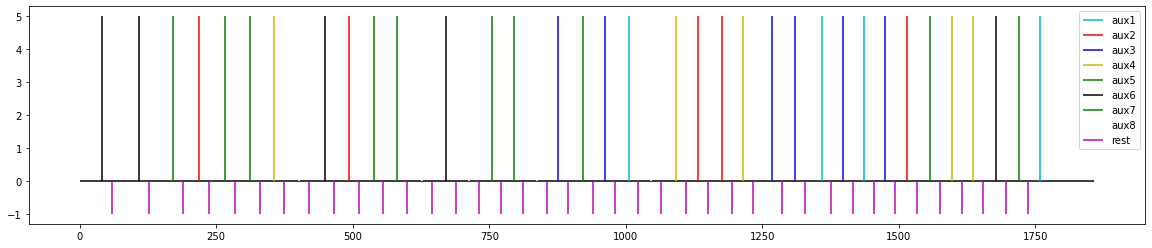

In [73]:
plot_stim_stimulus(data) 

In [74]:
start = []
stim_ = []

if stim_true:
  for s in stim_list[0:-1]:
    for i in range( data['nirs'][s]['data'].shape[0] ):
      start.append( data['nirs'][s]['data'][i,0] )
      stim_.append(s)


  df_temp = pd.DataFrame({'stim_':stim_, 'start':start}) 


In [75]:
df_temp = df_temp.sort_values('start')

In [76]:
df_temp.reset_index(drop=True, inplace=True)
df_temp

,stim_,start
0,stim6,41.7
1,stim6,109.0
2,stim5,171.7
3,stim2,219.2
4,stim5,266.8
5,stim7,312.2
6,stim4,355.6
7,stim8,401.7
8,stim6,448.4
9,stim2,493.0


# Ajusta os estímulos 1 e 3

In [77]:
df_temp[df_temp.stim_ == 'stim1']

,stim_,start
21,stim1,1005.2
29,stim1,1358.6
31,stim1,1436.8
39,stim1,1758.5


In [78]:
df_temp.groupby('stim_').stim_.count()

stim_
stim1    4
stim2    5
stim3    6
stim4    5
stim5    5
stim6    5
stim7    5
stim8    5
Name: stim_, dtype: int64

In [79]:
data['nirs']['stim3']['data'][:]

array([[ 876.6,   18. ,    5. ],
       [ 962.2,   18. ,    5. ],
       [1267.5,   18. ,    5. ],
       [1310. ,   18. ,    5. ],
       [1397.8,   18. ,    5. ],
       [1475.3,   18. ,    5. ]])

In [80]:
data['nirs']['stim1']['data'][:] 

array([[1005.2,   18. ,    5. ],
       [1358.6,   18. ,    5. ],
       [1436.8,   18. ,    5. ],
       [1758.5,   18. ,    5. ]])

In [81]:
stim_new =   np.array([np.array(data['nirs']['stim1']['data'][0]),
             np.array(data['nirs']['stim3']['data'][3]),
             np.array(data['nirs']['stim1']['data'][1]),
             np.array(data['nirs']['stim1']['data'][2]),
             np.array(data['nirs']['stim1']['data'][3])])

del data['nirs']['stim1']['data']
data['nirs']['stim1'].create_dataset('data', data=stim_new)

data['nirs']['stim1']['data'][:]

array([[1005.2,   18. ,    5. ],
       [1310. ,   18. ,    5. ],
       [1358.6,   18. ,    5. ],
       [1436.8,   18. ,    5. ],
       [1758.5,   18. ,    5. ]])

In [82]:
stim_new =   np.array([np.array(data['nirs']['stim3']['data'][0]),
             np.array(data['nirs']['stim3']['data'][1]),
             np.array(data['nirs']['stim3']['data'][2]),
             np.array(data['nirs']['stim3']['data'][4]),
             np.array(data['nirs']['stim3']['data'][5])])

del data['nirs']['stim3']['data']
data['nirs']['stim3'].create_dataset('data', data=stim_new)

data['nirs']['stim3']['data'][:]

array([[ 876.6,   18. ,    5. ],
       [ 962.2,   18. ,    5. ],
       [1267.5,   18. ,    5. ],
       [1397.8,   18. ,    5. ],
       [1475.3,   18. ,    5. ]])

In [83]:
stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

stim_name_set = set() 

for s in stim_list: 
  stim_name_set.add( data['nirs'][s]['name'][0].decode('utf8') )

stim_name_set = list(stim_name_set)
stim_name_set 

if stim_true:
  print( data['nirs'][stim_list[-1]]['data'][:] )

[[ 5.9700e+01  4.9300e+01 -1.0000e+00]
 [ 1.2700e+02  4.4700e+01 -1.0000e+00]
 [ 1.8970e+02  2.9500e+01 -1.0000e+00]
 [ 2.3720e+02  2.9600e+01 -1.0000e+00]
 [ 2.8480e+02  2.7400e+01 -1.0000e+00]
 [ 3.3020e+02  2.5400e+01 -1.0000e+00]
 [ 3.7360e+02  2.8100e+01 -1.0000e+00]
 [ 4.1970e+02  2.8700e+01 -1.0000e+00]
 [ 4.6640e+02  2.6600e+01 -1.0000e+00]
 [ 5.1100e+02  2.7100e+01 -1.0000e+00]
 [ 5.5610e+02  2.4500e+01 -1.0000e+00]
 [ 5.9860e+02  2.9000e+01 -1.0000e+00]
 [ 6.4560e+02  2.5600e+01 -1.0000e+00]
 [ 6.8920e+02  2.3600e+01 -1.0000e+00]
 [ 7.3080e+02  2.3400e+01 -1.0000e+00]
 [ 7.7220e+02  2.2400e+01 -1.0000e+00]
 [ 8.1260e+02  2.4800e+01 -1.0000e+00]
 [ 8.5540e+02  2.1200e+01 -1.0000e+00]
 [ 8.9460e+02  2.6800e+01 -1.0000e+00]
 [ 9.3940e+02  2.2800e+01 -1.0000e+00]
 [ 9.8020e+02  2.5000e+01 -1.0000e+00]
 [ 1.0232e+03  2.3200e+01 -1.0000e+00]
 [ 1.0644e+03  2.7900e+01 -1.0000e+00]
 [ 1.1103e+03  2.1500e+01 -1.0000e+00]
 [ 1.1498e+03  2.5900e+01 -1.0000e+00]
 [ 1.1937e+03  2.0800e+01

In [86]:
stim_aux = True

if stim_aux:
  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  stimulus_aux = channels_raw[['time']]

  for a in aux_list:
    stim_df = pd.DataFrame()
    stim_df[data['nirs'][a]['name'][0].decode('utf8')] = data['nirs'][a]['dataTimeSeries'][:]
    stimulus_aux = pd.concat([stimulus_aux,stim_df],axis=1)

  print(stimulus_aux.head())

   time  aux1  aux2  aux3  aux4  aux5  aux6  aux7  aux8
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
1   0.1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2   0.2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
3   0.3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
4   0.4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0


In [89]:
if stim_true:

  stimulus =  channels_raw[['time']]

  for s in stim_list:
    stim_df = pd.DataFrame()
    stim_df['time'] = data['nirs'][s]['data'][:,0]
    stim_df[s + '_duration'] = data['nirs'][s]['data'][:,1]
    stim_df[s] = data['nirs'][s]['data'][:,2]
    stimulus = pd.merge(stimulus,stim_df,how='left')

  stimulus = stimulus.fillna(0)
  print(stimulus)

         time  stim1_duration  stim1  ...  stim8  stim9_duration  stim9
0         0.0             0.0    0.0  ...    0.0             0.0    0.0
1         0.1             0.0    0.0  ...    0.0             0.0    0.0
2         0.2             0.0    0.0  ...    0.0             0.0    0.0
3         0.3             0.0    0.0  ...    0.0             0.0    0.0
4         0.4             0.0    0.0  ...    0.0             0.0    0.0
...       ...             ...    ...  ...    ...             ...    ...
18574  1857.4             0.0    0.0  ...    0.0             0.0    0.0
18575  1857.5             0.0    0.0  ...    0.0             0.0    0.0
18576  1857.6             0.0    0.0  ...    0.0             0.0    0.0
18577  1857.7             0.0    0.0  ...    0.0             0.0    0.0
18578  1857.8             0.0    0.0  ...    0.0             0.0    0.0

[18579 rows x 19 columns]


## Start Analysis with NME

In [91]:
!pip install nilearn

In [92]:
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip

  Using cached https://github.com/mne-tools/mne-python/archive/main.zip


In [93]:
!pip install mne-nirs

In [94]:
print(path_out + fname)

/content/snirf/JMVR_TCC_40.snirf


In [95]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)

In [96]:
import mne 
raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)

raw_intensity.load_data()

Loading /content/snirf/JMVR_TCC_40.snirf
Reading 0 ... 18578  =      0.000 ...  1857.800 secs...


<RawSNIRF | JMVR_TCC_40.snirf, 32 x 18579 (1857.8 s), ~4.6 MB, data loaded>

# Dowload file

In [97]:
from google.colab import files
files.download(path_out + fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
path_out + fname

'/content/snirf/JMVR_TCC_40.snirf'

In [99]:
os.system('cp ' + path_out + fname + ' ' + path_out + 'new_' + fname )  

0